# New York Stock Exhange Predictions RNN-LSTM

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
print(os.listdir("../input"))

['prices.csv', 'securities.csv', 'prices-split-adjusted.csv', 'fundamentals.csv']


In [31]:
df =  pd.read_csv('NYSE Data.csv', header=0)
df.head()

date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

In [32]:
print(df.shape)

(851264, 7)


In [33]:
df.symbol.unique()[0:20]

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN'], dtype=object)

In [34]:
print(len(df.symbol.values))

851264


In [35]:
df.describe()

open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       70.836986      70.857109      70.118414      71.543476   
std        83.695876      83.689686      82.877294      84.465504   
min         0.850000       0.860000       0.830000       0.880000   
25%        33.840000      33.849998      33.480000      34.189999   
50%        52.770000      52.799999      52.230000      53.310001   
75%        79.879997      79.889999      79.110001      80.610001   
max      1584.439941    1578.130005    1549.939941    1600.930054   

             volume  
count  8.512640e+05  
mean   5.415113e+06  
std    1.249468e+07  
min    0.000000e+00  
25%    1.221500e+06  
50%    2.476250e+06  
75%    5.222500e+06  
max    8.596434e+08

In [36]:
df.isnull().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [37]:
df.date.unique()

array(['2016-01-05 00:00:00', '2016-01-06 00:00:00',
       '2016-01-07 00:00:00', ..., '2016-12-28', '2016-12-29',
       '2016-12-30'], dtype=object)

**Some companies and their opening and closing stock prices.**
**Note: The differences is marginal , you might take open and close same but they are actually different after looking carefully.**

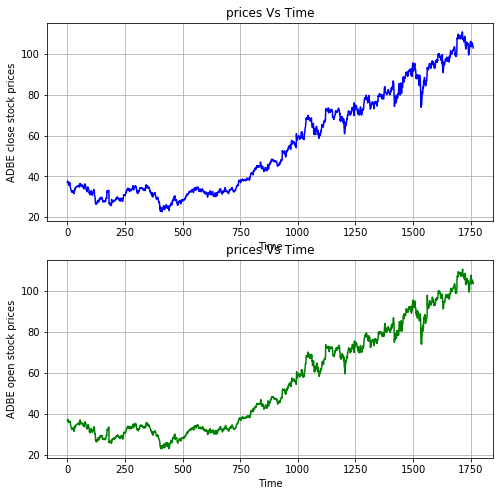

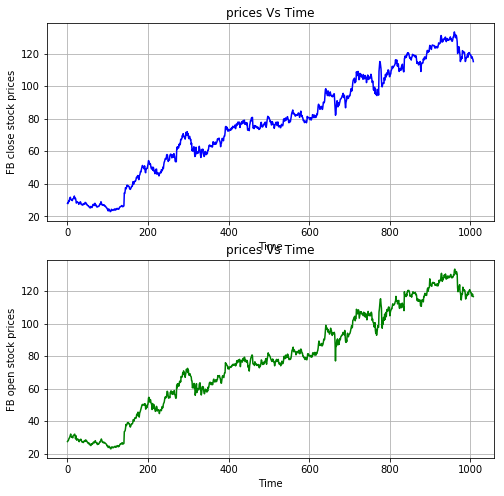

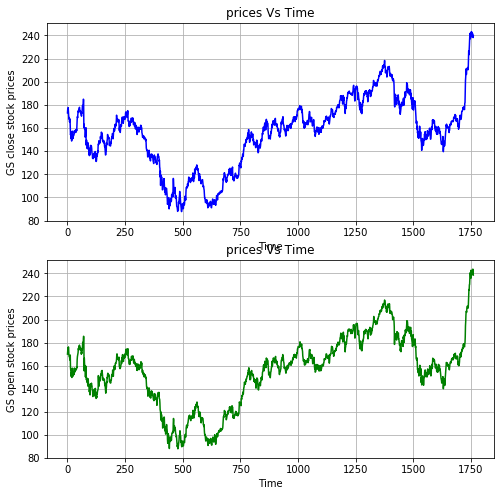

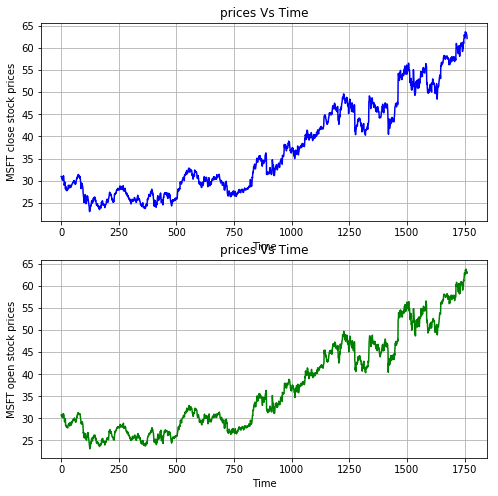

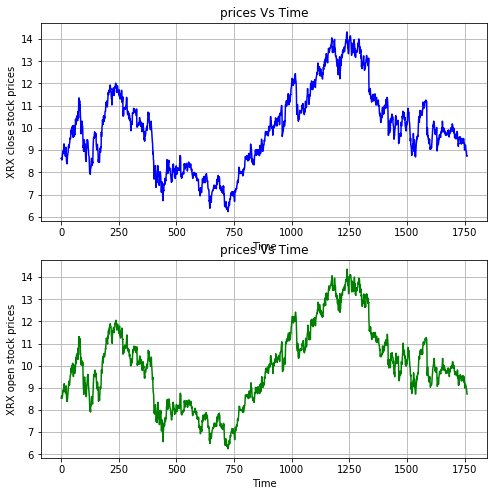

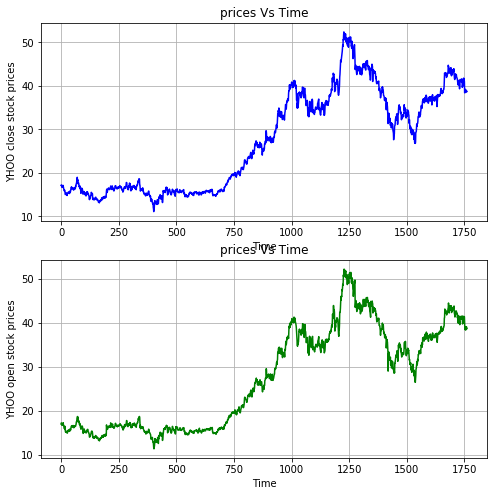

In [42]:
def plotter(code):
    global closing_stock
    global opening_stock
    f, axs = plt.subplots(2,2,figsize=(8,8))
    plt.subplot(212)
    company = df[df['symbol']==code]
    company = company.open.values.astype('float32')
    company = company.reshape(-1, 1)
    opening_stock = company
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel(code + " open stock prices")
    plt.title('prices Vs Time')
    plt.plot(company , 'g')
    
    plt.subplot(211)
    company_close = df[df['symbol']==code]
    company_close = company_close.close.values.astype('float32')
    company_close = company_close.reshape(-1, 1)
    closing_stock = company_close
    plt.xlabel('Time')
    plt.ylabel(code + " close stock prices")
    plt.title('prices Vs Time')
    plt.grid(True)
    plt.plot(company_close , 'b')
    plt.show()
for i in comp_plot:
    plotter(i)

**Lets take a single stock as a sample to forecast further stock prices.**

In [43]:
closing_stock[: , 0]

array([17.1 , 17.23, 17.17, ..., 38.73, 38.64, 38.67], dtype=float32)

In [44]:
stocks = closing_stock[: , 0]
print(stocks)
stocks = stocks.reshape(len(stocks) , 1)

[17.1  17.23 17.17 ... 38.73 38.64 38.67]


**Feature scaling the vector for better model performance.**

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
stocks = scaler.fit_transform(stocks)

In [48]:
train = int(len(stocks) * 0.80)
test = len(stocks) - train

In [49]:
print(train , test)

1409 353


In [50]:
train = stocks[0:train]
print(train)

[[0.14559111]
 [0.14874032]
 [0.14728683]
 ...
 [0.63372093]
 [0.6145833 ]
 [0.6196705 ]]


In [51]:
test = stocks[len(train) : ]

In [52]:
train = train.reshape(len(train) , 1)
test = test.reshape(len(test) , 1)

In [53]:
print(train.shape , test.shape)

(1409, 1) (353, 1)


**process_data for the required input for LSTM.**

In [54]:
def process_data(data , n_features):
    dataX, dataY = [], []
    for i in range(len(data)-n_features-1):
        a = data[i:(i+n_features), 0]
        dataX.append(a)
        dataY.append(data[i + n_features, 0])
    return np.array(dataX), np.array(dataY)

**Here I am taking 2 past values to predict a single value. This has already been checked and optimized after taking several cases.**

In [55]:
n_features = 2

trainX, trainY = process_data(train, n_features)
testX, testY = process_data(test, n_features)

In [56]:
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(1406, 2) (1406,) (350, 2) (350,)


**Reshaping again for required LSTM input as (sample , timestamp , features per sample).**

**Here I am taking timestamp as 1.**

In [57]:
trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

In [58]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam , SGD , RMSprop

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**Checkpointing the model when required and using other callbacks.**

In [59]:
filepath="stock_weights.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/callbacks.py:919: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.


## My personal tuned architecture for best performance on kaggle till date.

**The learning rate has been tuned for several times and so is the batch_size and the neurons in the layers.**

In [60]:
model = Sequential()
model.add(LSTM(256))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 256)            198912    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 740,737
Trainable params: 740,737
Non-trainable params: 0
_________________________________________________________________
None

In [64]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])

In [65]:
history = model.fit(trainX, trainY, epochs=100 , batch_size = 128 , 
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX,testY))    

Train on 1406 samples, validate on 350 samples
Epoch 1/100
1406/1406 [==============================] - 2s 1ms/step - loss: 8.5730e-04 - mean_squared_error: 8.5730e-04 - val_loss: 3.4262e-04 - val_mean_squared_error: 3.4262e-04

Epoch 00001: val_loss did not improve
Epoch 2/100
1406/1406 [==============================] - 0s 98us/step - loss: 7.6215e-04 - mean_squared_error: 7.6215e-04 - val_loss: 4.1608e-04 - val_mean_squared_error: 4.1608e-04

Epoch 00002: val_loss did not improve

Epoch 00002: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 3/100
1406/1406 [==============================] - 0s 99us/step - loss: 8.4767e-04 - mean_squared_error: 8.4767e-04 - val_loss: 3.3152e-04 - val_mean_squared_error: 3.3152e-04

Epoch 00003: val_loss did not improve

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.
Epoch 4/100
1406/1406 [==============================] - 0s 97us/step - loss: 7.2755e-04 - mean_squared_error: 7.2755e-04 - val_

1406/1406 [==============================] - 0s 99us/step - loss: 7.5330e-04 - mean_squared_error: 7.5330e-04 - val_loss: 3.2859e-04 - val_mean_squared_error: 3.2859e-04

Epoch 00059: val_loss did not improve
Epoch 60/100
1406/1406 [==============================] - 0s 98us/step - loss: 7.0811e-04 - mean_squared_error: 7.0811e-04 - val_loss: 3.2859e-04 - val_mean_squared_error: 3.2859e-04

Epoch 00060: val_loss did not improve
Epoch 61/100
1406/1406 [==============================] - 0s 97us/step - loss: 7.6382e-04 - mean_squared_error: 7.6382e-04 - val_loss: 3.2859e-04 - val_mean_squared_error: 3.2859e-04

Epoch 00061: val_loss did not improve
Epoch 62/100
1406/1406 [==============================] - 0s 98us/step - loss: 7.9563e-04 - mean_squared_error: 7.9563e-04 - val_loss: 3.2859e-04 - val_mean_squared_error: 3.2859e-04

Epoch 00062: val_loss did not improve
Epoch 63/100
1406/1406 [==============================] - 0s 97us/step - loss: 7.4980e-04 - mean_squared_error: 7.4980e-04 - 

1406/1406 [==============================] - 0s 98us/step - loss: 7.4128e-04 - mean_squared_error: 7.4128e-04 - val_loss: 3.2859e-04 - val_mean_squared_error: 3.2859e-04

Epoch 00096: val_loss did not improve
Epoch 97/100
1406/1406 [==============================] - 0s 105us/step - loss: 8.2424e-04 - mean_squared_error: 8.2424e-04 - val_loss: 3.2859e-04 - val_mean_squared_error: 3.2859e-04

Epoch 00097: val_loss did not improve
Epoch 98/100
1406/1406 [==============================] - 0s 99us/step - loss: 7.1726e-04 - mean_squared_error: 7.1726e-04 - val_loss: 3.2859e-04 - val_mean_squared_error: 3.2859e-04

Epoch 00098: val_loss did not improve
Epoch 99/100
1406/1406 [==============================] - 0s 96us/step - loss: 7.0614e-04 - mean_squared_error: 7.0614e-04 - val_loss: 3.2859e-04 - val_mean_squared_error: 3.2859e-04

Epoch 00099: val_loss did not improve
Epoch 100/100
1406/1406 [==============================] - 0s 103us/step - loss: 7.4282e-04 - mean_squared_error: 7.4282e-04

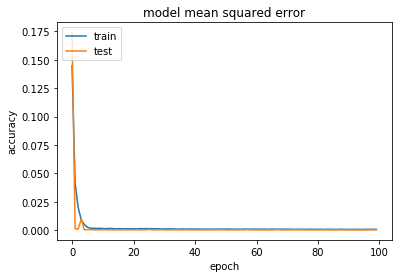

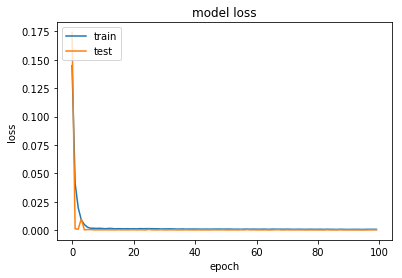

In [63]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## The score below is best on kaggle kernels till date.

## The mean square error for validation set is 0.000328 which is very low and good as well.

In [68]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, trainX, trainY , testX, testY)

Train Score: 0.00019 MSE (0.01 RMSE)
Test Score: 0.00033 MSE (0.02 RMSE)


(0.00019119656081728712, 0.0003285944225665714)

**Inverse transforming the scaled vector earlier and checking for the error visually in the graph.**

In [92]:
pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
pred[:10]

array([[36.707367],
       [35.363888],
       [35.62965 ],
       [36.36585 ],
       [36.40129 ],
       [36.104248],
       [35.64992 ],
       [34.80877 ],
       [33.6898  ],
       [32.265743]], dtype=float32)

In [93]:
testY = testY.reshape(testY.shape[0] , 1)
testY = scaler.inverse_transform(testY)
testY[:10]

array([[34.49    ],
       [35.93    ],
       [36.24    ],
       [36.1     ],
       [35.69    ],
       [35.19    ],
       [34.1     ],
       [32.93    ],
       [31.31    ],
       [31.739998]], dtype=float32)

## The space between the predicted (red) and actual (blue) line is self explanatory for the model tuning and performance.

Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices


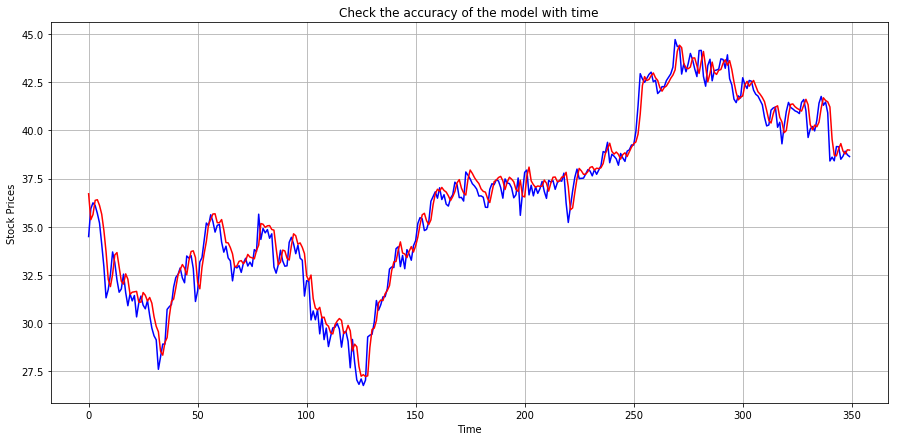

In [91]:
print("Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(testY , 'b')
plt.plot(pred , 'r')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Check the accuracy of the model with time')
plt.grid(True)
plt.show()